## Following the tutorial at:
http://strimas.com/spatial/hexagonal-grids/

In [2]:
suppressMessages(library(dplyr))
library(tidyr)
library(sp)
suppressMessages(library(raster))
suppressMessages(library(rgeos))
library(rgbif)
library(viridis)
library(gridExtra)
library(rasterVis)
set.seed(1)

Loading required package: viridisLite

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: lattice
Loading required package: latticeExtra
Loading required package: RColorBrewer


Need to make the path... this is where it is saving the files to.

In [3]:
study_area <- getData("GADM", country = "USA", level = 0, path="data/hex-grids") %>%
    disaggregate %>% 
    geometry

In [4]:
study_area <- sapply(study_area@polygons, slot, "area") %>% 
  {which(. == max(.))} %>% 
  study_area[.]

In [5]:
clip_list <- c(-80, -70, 35, 45)
study_area <- crop(study_area, clip_list)

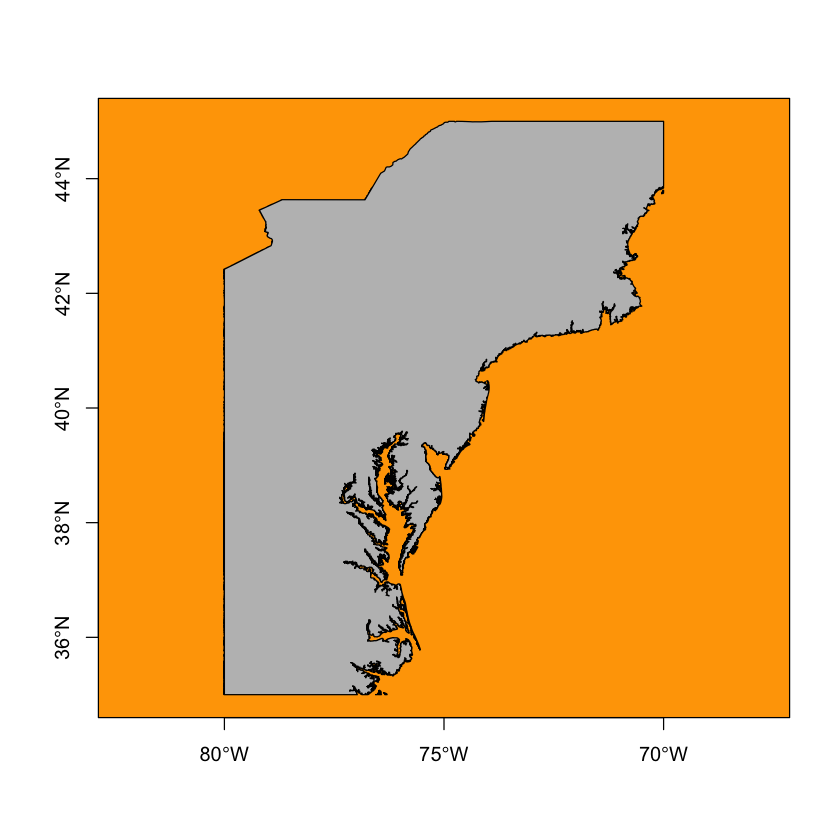

In [7]:
#plot(study_area, col="gray", bg="orange", axes=TRUE)

### Overlay hexagonal grids

In [6]:
source("make_grid.r")

In [7]:
# Convert to raster
study_area_utm <- CRS("+proj=utm +zone=14 +datum=WGS84 +units=km +no_defs") %>% 
  spTransform(study_area, .)

In [8]:
hex_grid <- make_grid(study_area_utm, type = "hexagonal", cell_area = 625, clip = FALSE)

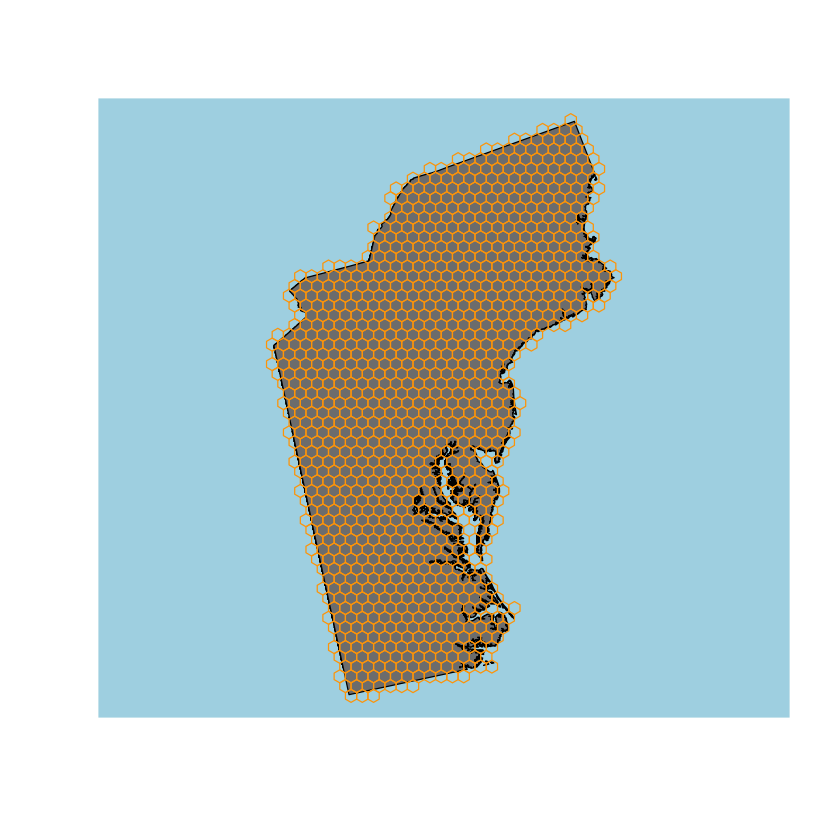

In [10]:
plot(study_area_utm, col = "grey50", bg = "light blue", axes = FALSE)
plot(hex_grid, border = "orange", add = TRUE)

## Ebird test
This somehow broke. Not sure how.

In [13]:
library(rebird)
ebird_key <- "4fa7b334-ce0d-4e88-aaae-2e0c138d049e"
bird_families <- c("Corvidae", "Ardeidae")
families <- data_frame(family = bird_families) %>% 
  group_by(family) %>% 
  do(name_suggest(q = .$family, rank = "family")) %>% 
  filter(family == canonicalName) %>% 
  dplyr::select(family, key)
gb <- occ_search(taxonKey = families$key, country = "US", datasetKey = ebird_key, 
                 limit = 3000, return = "data",
                 fields = c("family", "species", "decimalLatitude", "decimalLongitude"),
                 hasCoordinate = TRUE, hasGeospatialIssue = FALSE) %>% 
  bind_rows %>% 
  rename(lng = decimalLongitude, lat = decimalLatitude) %>% 
  as.data.frame

ERROR: Error: Max limit of 300 exceeded


In [14]:
coordinates(gb) <- ~ lng + lat
projection(gb) <- projection(study_area)
gb <- spTransform(gb, projection(study_area_utm)) #needs to be spTranformed layer (studyareautm)

ERROR: Error in coordinates(gb) <- ~lng + lat: object 'gb' not found


In [12]:
fill_missing <- expand.grid(id = row.names(hex_grid), 
                            family = bird_families, stringsAsFactors = FALSE)

In [13]:
point_density <- over(hex_grid, gb, returnList = TRUE) %>% 
  plyr::ldply(.fun = function(x) x, .id = "id") %>%
  mutate(id = as.character(id)) %>% 
  count(id, family) %>% 
  left_join(fill_missing, ., by = c("id", "family")) %>%
  # log transform
  mutate(n = ifelse(is.na(n), -1, log10(n))) %>% 
  spread(family, n, fill = -1) %>% 
  SpatialPolygonsDataFrame(hex_grid, .)

### This plots the data but need to mess with axes.

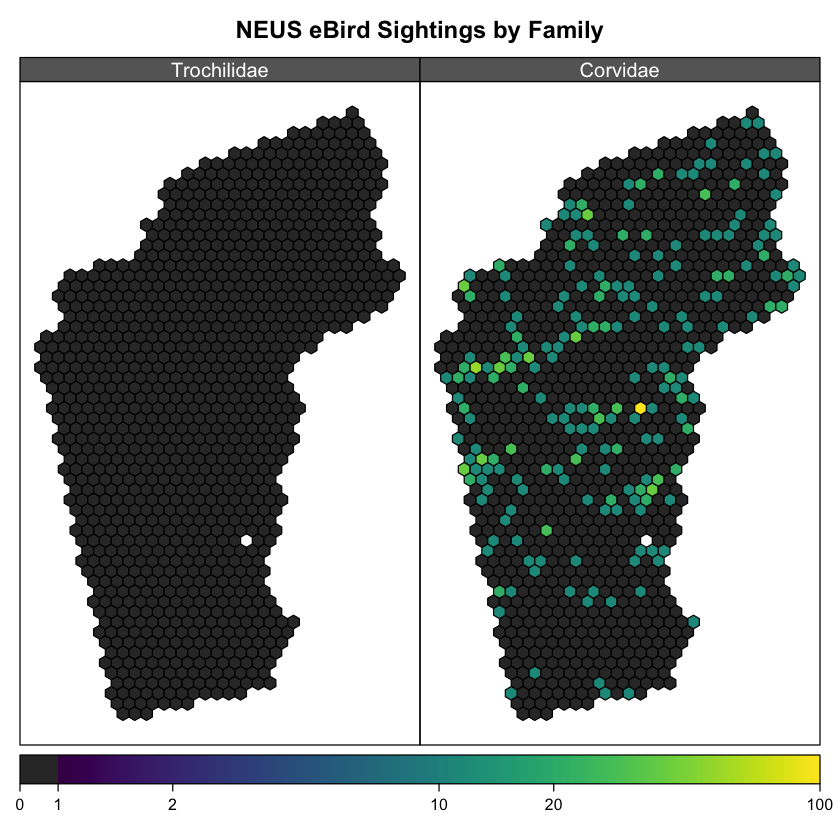

In [14]:
spplot(point_density, bird_families,
       main = "NEUS eBird Sightings by Family",
       col.regions = c("grey20", viridis(255)),
       colorkey = list(
         space = "bottom",
         at = c(-0.1, seq(0, log10(2500), length.out = 255)),
         labels = list(
           at = c(-0.1, log10(c(1, 100, 1000, 2500))),
           labels = c(0, 1, 100, 1000, 2500)
           )
         ),
       xlim = bbexpand(bbox(point_density)[1, ], 0.04), 
       ylim = bbexpand(bbox(point_density)[2, ], 0.04),
       par.strip.text = list(col = "white"),
       par.settings = list(
         strip.background = list(col = "grey40"))
       )

## Test to see if I can get Ecuador data from GADM

In [ ]:
#ecuador <- getData(name = "GADM", country = "USA", level = 0, 
#                   path = "data/hex-grids/") %>% 
#  disaggregate %>% 
#  geometry
## project
#ecuador <- crop(ecuador, clip_list)
#ecuador <- spTransform(ecuador, CRS("+proj=utm +zone=17 +datum=WGS84 +units=km +no_defs"))
#hex_ecu <- make_grid(ecuador, type = "hexagonal", cell_area = 625, clip = FALSE)

In [23]:
#srtm <- getData('alt', country = 'US', path = "data/hex-grids/")

returning a list of RasterLayer objects


In [26]:
r <- raster("~/Downloads/F182013.v4/F182013.v4c_web.avg_vis.tif")
r <- crop(r, clip_list)

In [27]:
r <- projectRaster(r, to=raster(hex_grid, res=1))

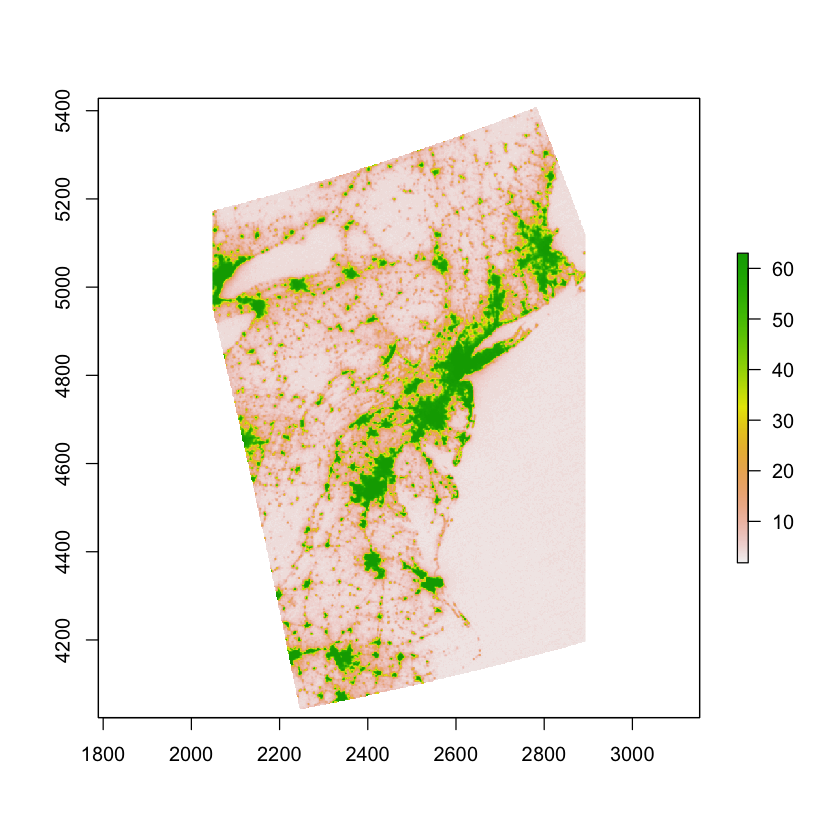

In [22]:
plot(r)

In [28]:
hex_light <- extract(r, hex_grid, fun=sum, na.rm=TRUE, sp=TRUE)

In [35]:
class(hex_light)

[1] "SpatialPolygonsDataFrame"
attr(,"package")
[1] "sp"

In [37]:
hex_light.df <- as.data.frame(hex_light)
hex_light.df

F182013.v4c_web.avg_vis
<dbl>
724.65488
736.71757
30.71601
1226.92147
3557.17040
9757.55993
7483.77951
19749.17535
2851.02856


In [33]:
p1 <- levelplot(r, 
                col.regions = terrain.colors,
                margin = FALSE, scales = list(draw = FALSE),
                colorkey = list(
                  #space = "bottom",
                  at = seq(0, 60, length.out = 256),
                  labels = list(at = 10 * 0:6, 
                                labels = format(10 * 0:6, big.mark = ","))
                )
      )
p2 <- spplot(hex_light,
             col.regions = terrain.colors(256),
             at = seq(0, 40000, length.out = 256),
             colorkey = list(
               labels = list(at = seq(0, 40000, 5000), 
                             labels = format(seq(0, 40000, 5000), big.mark = ","))
             )
      )


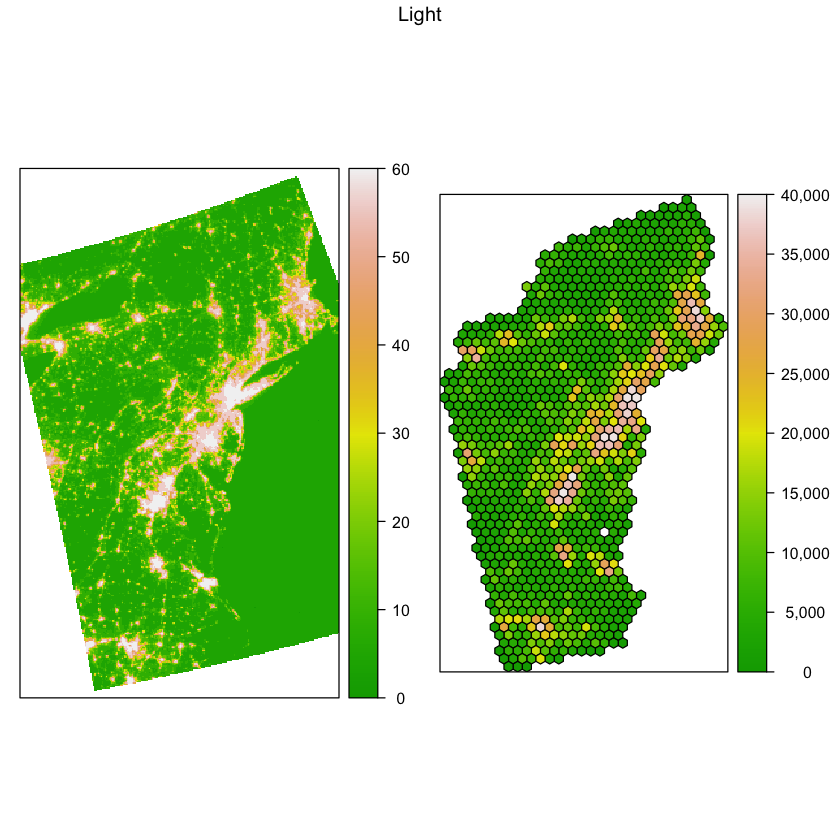

In [34]:
grid.arrange(p1, p2, ncol = 2, top = "Light")